# Tennis: Collaboration and Competition

---

### 1.- Setting the environment

In [1]:
%config IPCompleter.greedy=True
from unityagents import UnityEnvironment
import numpy as np
from datetime import datetime

aws_unity_filename= './Tennis_Linux_NoVis/Tennis.x86_64'
laptop_unity_filename= './Tennis_Linux/Tennis.x86_64'
seed= 0 #datetime.now().second
env = UnityEnvironment(seed= seed, file_name= laptop_unity_filename)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#Handy functions to help understand the code
def env_reset(env, train=True):
    env_info = env.reset(train_mode= train)[env.brain_names[0]]
    return env_info.vector_observations, len(env_info.agents)

def env_step(env, action):
    env_info= env.step(action)[env.brain_names[0]]
    return env_info.vector_observations, env_info.rewards, env_info.local_done

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2.- Agents definition

In [2]:
import torch
from torch.autograd import Variable
from glob import glob
import re
import math

from ddpg import DDPG

class Agents:
    def __init__(self, num_agents=1, config= None):
        if not config: 
            raise OSError('DDPG: no configuration parameter in class init')
        self.config= config
        self.num_agents= num_agents
        self.agents= []
        self.scores= []
        for i in range(num_agents):
            self.agents.append( DDPG(config= config) )
    
    def reset(self):
        for agent in self.agents: 
            agent.reset()
            
    def act(self, states, train= True):
        actions= np.array([])
        for i, agent in zip(range(self.num_agents), self.agents):
            actions= np.append(actions, agent.act( states[i], train ) )
        return actions
    
    def step(self, state, action, reward, next_state, done):
        # states and action are numpy arrays while reward and done are lists
        # Single experience replay
        """
        for i, agent in zip(range(self.num_agents), self.agents):
            action_size= agent.action_size
            agent.step(state[i], action[action_size*i:(action_size*i)+action_size], reward[i], next_state[i], done[i])
        """
        # Combined experience replay
        for agent in self.agents:
            for i in range(self.num_agents):
                s= slice(agent.action_size*i, (agent.action_size*i)+ agent.action_size)
                agent.memory.add(state[i], action[s], reward[i], next_state[i], done[i])
            if len(agent.memory) >= agent.batch_size:
                agent.learn()
            
    def update(self, score):
        self.scores.append(score)
        if (len(self.scores)> 0) and (score > np.max(self.scores)):    # Save actors for best score
            for i, agent in zip(range(self.num_agents), self.agents):
                torch.save(agent.actor.state_dict(), "last_actor_{}.pth".format(i+ 1))
        """
        # Update agent
        if not self.config["param_noise"]: return 0.0
        dists= []
        for agent in self.agents:
            #agent.update()
            #states, perturbed_actions= agent.action_memory.pop()
            states, perturbed_actions, _, _, _= agent.memory.sample(1024)
            #states, perturbed_actions, _, _, _= agent.memory.get(agent.steps * self.num_agents)
            #states, perturbed_actions, _, _, _= agent.memory.get(1024)
            unperturbed_actions = agent.act(states, False)
            ddpg_dist = agent.param_noise.distance(perturbed_actions.numpy(), unperturbed_actions)
            
            agent.param_noise.adapt(ddpg_dist)
            dists.append(ddpg_dist)
            
        return np.mean(dists)
        """
                                      
    def save(self):
        data= {"config": self.config, "scores": self.scores,}
        fname= "./{}_".format(self.__class__.__name__)
        last_index= 1
        files= sorted(glob("{}*.data".format(fname)))
        if files:
            last= files[-1]
            if last: 
                last_index= int(re.findall('[0-9]+', last, flags=re.IGNORECASE)[0])
                last_index+= 1
        filename= "{}{}.data".format(fname, last_index)
        torch.save(data, filename)
        # Last actor for all agents
        for i, agent in zip(range(self.num_agents), self.agents):
            torch.save(agent.actor.state_dict(), "last_actor_{}.pth".format(i+ 1))
            
    def load(self):
        for i, agent in zip(range(self.num_agents), self.agents):
            model= torch.load("last_actor_{}.pth".format(i+ 1), map_location=lambda storage, loc: storage)
            agent.actor.load_state_dict(model)
        
    def eval(self):
        for agent in self.agents:
            agent.actor.eval() 


### 3.- Training

Episode 100	Average Score: 0.04   
Episode 200	Average Score: 0.03   
Episode 300	Average Score: 0.04   
Episode 400	Average Score: 0.07   
Episode 500	Average Score: 0.11   
Episode 576	Average Score: 0.50   
Environment solved in 476 episodes!	Average Score: 0.50


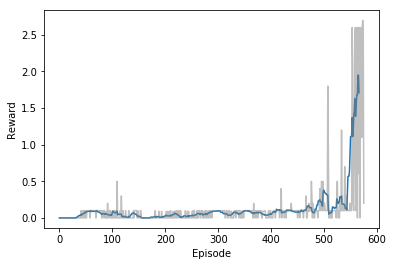

Elapsed time 0:20:51.439946


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from collections import deque
from datetime import datetime

from ddpg import DDPG

NUM_EPISODES = 3000
SOLVED_IN= 0.5

start= datetime.now()

states, num_agents= env_reset(env, True)

# Hyperparameters
config= {
    "label": "Noisy layerNorm copy",
    "state_size": states.shape[1],
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "actor_nodes": [32, 32],
    "critic_nodes": [128, 128],
    "batch_size": 256,
    "memory_size": 100000,
    "discount": 0.9,
    "tau": 0.001,
    "action_noise": "No",    # Options: No, Normal, OU, 
    "sigma": 0.1,            # OUNoise, Normal
    #"param_noise": True,
    #"noise_scale": 0.3,      # initial noise scale for param noise (default: 0.3)
    "critic_l2_reg": 0.0,  # 1e-2
}


scores_window = deque(maxlen=100)
                     
agents= Agents(num_agents, config= config)

for episode in range(NUM_EPISODES):
    states, _= env_reset(env, True)
    agents.reset()
    score = np.zeros(num_agents)
    
    while True:
        actions= agents.act(states)    # Agent action. Include noise
        next_states, rewards, dones= env_step(env, actions)   # Environmet step
        # Agent step. Includes learnig from memory
        agents.step(states, actions, rewards, next_states, dones)
        
        score+= rewards        # update the score
        states= next_states     # roll over the state to next time step
        if np.any(dones):              # exit loop if episode finished
            break
    
    
    max= np.max(score)
    agents.update(max)          # Add score to agents and update param noise
    scores_window.append(max)       
    mean_w_scores= np.mean(scores_window)
    print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores), end="")
    if (episode+ 1) % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}   '.format(episode+ 1, mean_w_scores))
    if mean_w_scores >= SOLVED_IN:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format((episode+ 1)-100, mean_w_scores))
        break
    
        
agents.save()


        
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_scores= running_mean(agents.scores, 10)
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores)
plt.plot(np.arange(len(agents.scores)), agents.scores, color='grey', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.show()
print('Elapsed time', datetime.now()- start)

### 4.- See how the agent behaves

In [4]:
states, num_agents= env_reset(env, False)

config= {
    "label": "Noise",
    "state_size": states.shape[1],
    "action_size": brain.vector_action_space_size,
    "seed": seed,
    "actor_lr": 0.001,
    "critic_lr": 0.001,
    "actor_nodes": [128, 128],
    "critic_nodes": [128, 128],
    "batch_size": 512,
    "memory_size": 100000,
    "discount": 0.9,
    "sigma": 0.1, # OUNoise
    "tau": 0.001,
}

agents= Agents(num_agents, config= config)

agents.load()
agents.eval()

score = np.zeros(num_agents)                       # initialize the score
while True:
    #print(type(states), states)
    actions= agents.act(states, False)
    #agents.eval()
    next_states, rewards, dones= env_step(env, actions)
    score += rewards                                # update the score
    states= next_states   
    if np.any(dones):                                       # exit loop if episode finished
        break
    
print("\rFinal score: {:.1f}".format(np.max(score)))

RuntimeError: Error(s) in loading state_dict for Actor:
	While copying the parameter named "model.1.bias_sigma", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.1.bias_epsilon", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.1.bias_mu", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.1.weight_epsilon", whose dimensions in the model are torch.Size([128, 24]) and whose dimensions in the checkpoint are torch.Size([32, 24]).
	While copying the parameter named "model.1.weight_sigma", whose dimensions in the model are torch.Size([128, 24]) and whose dimensions in the checkpoint are torch.Size([32, 24]).
	While copying the parameter named "model.1.weight_mu", whose dimensions in the model are torch.Size([128, 24]) and whose dimensions in the checkpoint are torch.Size([32, 24]).
	While copying the parameter named "model.3.running_mean", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.3.running_var", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.3.weight", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.3.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.4.bias_sigma", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.4.bias_epsilon", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.4.bias_mu", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.4.weight_epsilon", whose dimensions in the model are torch.Size([128, 128]) and whose dimensions in the checkpoint are torch.Size([32, 32]).
	While copying the parameter named "model.4.weight_sigma", whose dimensions in the model are torch.Size([128, 128]) and whose dimensions in the checkpoint are torch.Size([32, 32]).
	While copying the parameter named "model.4.weight_mu", whose dimensions in the model are torch.Size([128, 128]) and whose dimensions in the checkpoint are torch.Size([32, 32]).
	While copying the parameter named "model.6.running_mean", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.6.running_var", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.6.weight", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.6.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([32]).
	While copying the parameter named "model.7.weight_epsilon", whose dimensions in the model are torch.Size([2, 128]) and whose dimensions in the checkpoint are torch.Size([2, 32]).
	While copying the parameter named "model.7.weight_sigma", whose dimensions in the model are torch.Size([2, 128]) and whose dimensions in the checkpoint are torch.Size([2, 32]).
	While copying the parameter named "model.7.weight_mu", whose dimensions in the model are torch.Size([2, 128]) and whose dimensions in the checkpoint are torch.Size([2, 32]).

### Explore directory

In [ ]:
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N


plt.figure(figsize=(15, 6))

files= glob("*.data")

for file in sorted(glob("*.data")):
    data= torch.load(file)
    scores= data["scores"]
    smoothed_scores= running_mean(scores, 10)
    # Label
    # Label
    label= "Critic lr: "
    if "label" in data["config"]:
        label= "Sigma: {}".format(data["config"]["sigma"])
    plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, label= label)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
# Print models
print(agents.agents[0].actor)
print(agents.agents[0].critic)